In [1]:
# Load the necessary imports for data prep, split, for modelling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
print("Packages loaded successfully!")

Packages loaded successfully!


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv") # Reading csv data into pandas dataframe
df.columns = df.columns.str.lower().str.replace(' ', '_') # Converting column names into lowercase then replace spaces with underscore
categorical_columns = list(df.dtypes[df.dtypes == "object"].index) # Retrieving categorical columns

for c in categorical_columns:
    df[c] = df[c].str.lower().replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce') # Converting totalcharges to numeric then using coerce to avoid errors
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
# Trainining, test , and validation split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
# Selecting numerical and categorical features
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = ['gender', 
               'seniorcitizen', 
               'partner', 
               'dependents', 
               'phoneservice', 
               'multiplelines', 
               'internetservice', 
               'onlinesecurity', 
               'onlinebackup', 
               'deviceprotection', 
               'techsupport', 
               'streamingtv', 
               'streamingmovies', 
               'contract', 
               'paperlessbilling', 
               'paymentmethod']

In [6]:
# Instantiating DictVectorizer. This hepls in one-hot encoding
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

# creating the model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
# Validating the trained model
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

1132

In [10]:
(y_val == churn_decision).mean()

0.8034066713981547

#### **Evaluate the model on Different thresholds**
The question now is whether we have chosen a good value for the threshold

In [11]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [12]:
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


It appears that 0.5 is indeed the best threshold on the validation set. This suggests that the default threshold of 0.5 is an appropriate choice for our model in this context.

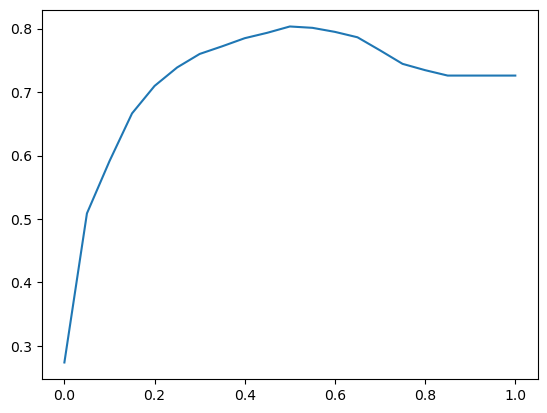

In [13]:
plt.plot(thresholds, scores)
plt.show()

In [14]:
# Let's use Scikit-Learn, before we used our custom function
from sklearn.metrics import accuracy_score
 
thresholds = np.linspace(0, 1, 21)
scores = []
 
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


#### **Check Accuracy of Dummy Baseline**

In [15]:
from collections import Counter
 
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [16]:
# Distribution of y_val
Counter(y_val)

Counter({0: 1023, 1: 386})

In [17]:
1023 / 1409

0.7260468417317246

In [18]:
y_val.mean()

0.2739531582682754

In [19]:
1 - y_val.mean()

0.7260468417317246

We can observe that there are significantly more non-churning customers than churning ones, with only 27% being churning customers and 73% being non-churning customers. This situation highlights a common challenge known as class imbalance, where one class has far more samples than the other. Incase of class imbalance, the traditional accuracy metric can be misleading.

#### Confusion Table/Matrix

In [20]:
# people who are going to churn
actual_positive = (y_val == 1)
# people who are not going to churn
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [21]:
predict_positive & actual_positive

array([False, False, False, ..., False,  True,  True])

In [22]:
tp = (predict_positive & actual_positive).sum()
tp

210

In [23]:
tn = (predict_negative & actual_negative).sum()
tn

922

In [24]:
fp = (predict_positive & actual_negative).sum()
fp

101

In [25]:
fn = (predict_negative & actual_positive).sum()
fn

176

In [26]:
# Arranging them in table
confusion_matrix = np.array([
    [tn, fp], 
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [27]:
# Expressing these values in realtive terms to gain a better perspective on model performance instead of absolute terms
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

#### Precision and Recall

In [28]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

0.8034066713981547

In [29]:
precision = tp / (tp + fp)
precision

0.6752411575562701

In [30]:
# --> promotional email goes to 311 people, but 210 are actually going to churn (--> 33% are mistakes)
tp + fp

311

In [31]:
recall = tp / (tp + fn)
recall

0.5440414507772021

In [32]:
# --> For 46% of people who are churning we failed to identify them
tp + fn

386

#### ROC Curve (Receiver Operating Characteristics

In [33]:
tpr = tp / (tp + fn)
print(f"True positive rate: {tpr}")
print(f"Recall: {recall}")

True positive rate: 0.5440414507772021
Recall: 0.5440414507772021


In [34]:
fpr = fp / (fp + tn)
print(f"False positive rate: {fpr}")

False positive rate: 0.09872922776148582


In [35]:
scores = []
thresholds = np.linspace(0, 1, 101)
 
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
 
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
 
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
 
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
 
    scores.append((t, tp, tn, fp, fn))
 
scores

[(0.0, 386, 0, 1023, 0),
 (0.01, 385, 110, 913, 1),
 (0.02, 384, 193, 830, 2),
 (0.03, 383, 257, 766, 3),
 (0.04, 381, 308, 715, 5),
 (0.05, 379, 338, 685, 7),
 (0.06, 377, 362, 661, 9),
 (0.07, 372, 382, 641, 14),
 (0.08, 371, 410, 613, 15),
 (0.09, 369, 443, 580, 17),
 (0.1, 366, 467, 556, 20),
 (0.11, 365, 495, 528, 21),
 (0.12, 365, 514, 509, 21),
 (0.13, 360, 546, 477, 26),
 (0.14, 354, 570, 453, 32),
 (0.15, 351, 588, 435, 35),
 (0.16, 347, 604, 419, 39),
 (0.17, 346, 622, 401, 40),
 (0.18, 344, 639, 384, 42),
 (0.19, 338, 653, 370, 48),
 (0.2, 333, 667, 356, 53),
 (0.21, 330, 682, 341, 56),
 (0.22, 323, 701, 322, 63),
 (0.23, 320, 710, 313, 66),
 (0.24, 316, 720, 303, 70),
 (0.25, 309, 732, 291, 77),
 (0.26, 304, 742, 281, 82),
 (0.27, 303, 753, 270, 83),
 (0.28, 295, 767, 256, 91),
 (0.29, 291, 779, 244, 95),
 (0.3, 284, 787, 236, 102),
 (0.31, 280, 793, 230, 106),
 (0.32, 278, 797, 226, 108),
 (0.33, 276, 802, 221, 110),
 (0.34, 274, 811, 212, 112),
 (0.35000000000000003, 272,

In [36]:
# turn to dataframe
columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,tn,fp,fn
0,0.00,386,0,1023,0
1,0.01,385,110,913,1
2,0.02,384,193,830,2
3,0.03,383,257,766,3
4,0.04,381,308,715,5
...,...,...,...,...,...
96,0.96,0,1023,0,386
97,0.97,0,1023,0,386
98,0.98,0,1023,0,386
99,0.99,0,1023,0,386


In [37]:
df_scores[::10] # looking at each tenth record

,threshold,tp,tn,fp,fn
0,0.0,386,0,1023,0
10,0.1,366,467,556,20
20,0.2,333,667,356,53
30,0.3,284,787,236,102
40,0.4,249,857,166,137
50,0.5,210,922,101,176
60,0.6,150,970,53,236
70,0.7,76,1003,20,310
80,0.8,13,1022,1,373
90,0.9,0,1023,0,386


In [38]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[:: 10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,366,467,556,20,0.948187,0.543500
20,0.2,333,667,356,53,0.862694,0.347996
30,0.3,284,787,236,102,0.735751,0.230694
40,0.4,249,857,166,137,0.645078,0.162268
50,0.5,210,922,101,176,0.544041,0.098729
60,0.6,150,970,53,236,0.388601,0.051808
70,0.7,76,1003,20,310,0.196891,0.019550
80,0.8,13,1022,1,373,0.033679,0.000978
90,0.9,0,1023,0,386,0.000000,0.000000


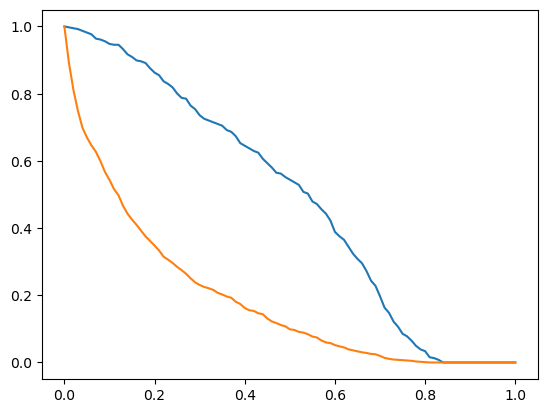

In [39]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.show()

#### Random model

In [40]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [41]:
# Accuracy for our random model is around 50%
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [42]:
# Let’s put the previously used code into a function.
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
 
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
 
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
 
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
 
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
 
        scores.append((t, tp, tn, fp, fn))
 
    columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
    df_scores = pd.DataFrame(scores, columns=columns)
 
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
 
    return df_scores

In [43]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


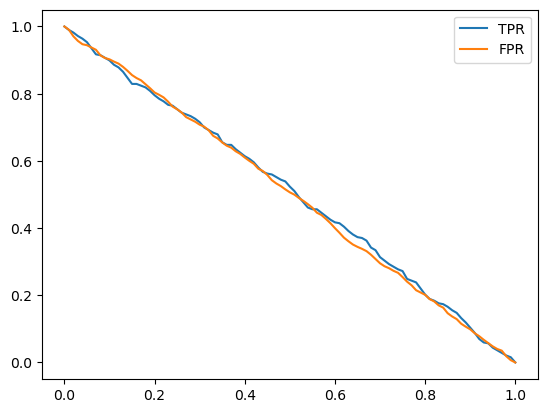

In [44]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()
plt.show()

#### Ideal model
Now, let’s discuss the concept of an ideal model that makes correct predictions for every example. To implement this, we need to determine the number of negative examples, which corresponds to the number of people who are not churning in our dataset.

In [45]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

To create the ideal model’s predictions for our validation set, we first create a y_ideal array that contains only negative observations (0s) followed by positive observations (1s). We use the np.repeat() function to achieve this, creating an array with 1023 zeros and then 386 ones.

In [46]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

To create our predictions for the ideal model, which are numbers between 0 and 1, we can use the np.linspace() function to generate an array of evenly spaced values between 0 and 1. This array should have the same length as y_ideal, which is 1409 in this case.

In [47]:
y_ideal_pred = np.linspace(0, 1, len(y_ideal))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [48]:
1 - y_val.mean()

0.7260468417317246

In [49]:
accuracy_ideal = ((y_ideal_pred >= 0.726) == y_ideal).mean()
accuracy_ideal

1.0

The ideal model, which makes perfect predictions, doesn’t exist in reality, but it serves as a benchmark to understand how well our actual model is performing. By comparing our model’s performance to that of the ideal model, we can assess how much room for improvement there is.

In [50]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,386,141,882,0,1.000000,0.862170
20,0.2,386,282,741,0,1.000000,0.724340
30,0.3,386,423,600,0,1.000000,0.586510
40,0.4,386,564,459,0,1.000000,0.448680
50,0.5,386,704,319,0,1.000000,0.311828
60,0.6,386,845,178,0,1.000000,0.173998
70,0.7,386,986,37,0,1.000000,0.036168
80,0.8,282,1023,0,104,0.730570,0.000000
90,0.9,141,1023,0,245,0.365285,0.000000


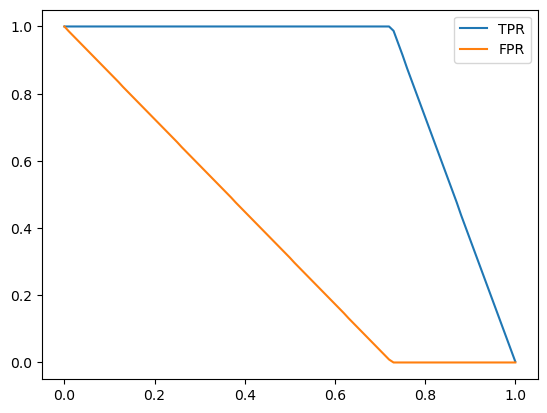

In [51]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()
plt.show()

What we see here is that TPR almost always stays around 1 and starts to go down after the threshold of 0.726. So, this model can correctly identify churning customers up to that threshold. For people who are not churning but are classified as churning by the model when the threshold is below 0.726, the model is not always correct. However, the detection becomes always true after the threshold of 0.726.

Let’s take another example with a threshold of 0.4. The FPR is around 45%, and the model makes some mistakes. So, for around 32% of people who are predicted as non-churning when the threshold is set to 0.726 but are below that threshold, we predict them as churning even though they are not.

#### Putting everything together
Now let’s try to plot all the models together so we can hold the benchmarks together.

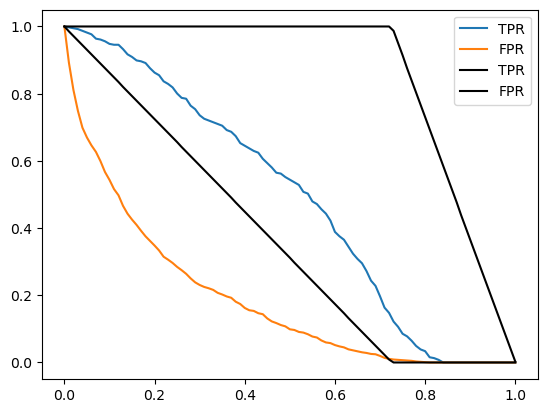

In [52]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
 
#plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
#plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
 
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color = 'black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color = 'black')
 
plt.legend()
plt.show()

We see that our TPR is far from the ideal model. We want it to be as close as possible to 1. We also notice that our FPR is significantly different from that of the ideal model. Plotting against the threshold is not always intuitive. For example, in our model, the best threshold is 0.5, as we know from accuracy. However, for the ideal model, as we saw earlier, the best threshold is 0.726. So they have different thresholds. What we can do to better visualize this is to plot FPR against TPR. On the x-axis, we’ll have FPR, and on the y-axis, we’ll have TPR. To make it easier to understand, we can also add the benchmark lines.

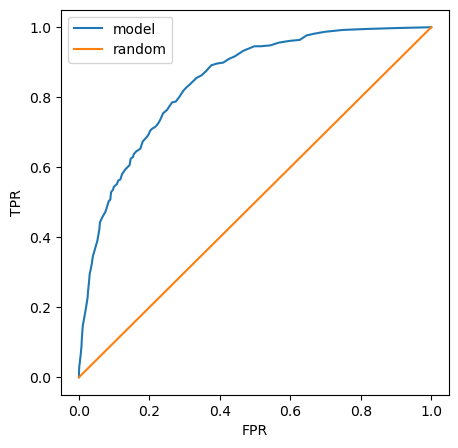

In [53]:
plt.figure(figsize=(5,5))
 
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

In the curve of the ideal model, there is one crucial point, often referred to as the ‘north star’ or ideal spot, located in the upper-left corner where TPR is 100% and FPR is 0%. This point represents the optimal performance we aim to achieve with our model. A ROC curve visualizes this by plotting TPR against FPR, and we usually add a diagonal random baseline. Our goal is to make our model’s curve as close as possible to this ideal spot, which means simultaneously being as far away as possible from the random baseline. In essence, if our model closely resembles the random baseline model, it is not performing well.

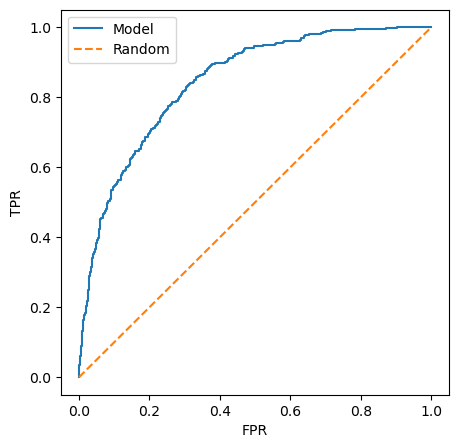

In [54]:
# We can also use the ROC functionality of scikit learn package
from sklearn.metrics import roc_curve
 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
 
plt.figure(figsize=(5,5))
 
plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='Random', linestyle='--')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

### **What kind of information do we get from ROC curve?**

Let’s begin in the lower-left corner, where both TPR and FPR are 0. This occurs at higher thresholds like 1.0. In this scenario, we predict that every customer is non-churning, resulting in TPR being 0 since we don’t predict anyone as churning. FPR is also 0 because there are no false positives; we only have true negatives (TN).

As we move from the lower left corner, where the threshold starts at 1.0, we eventually reach the upper-right corner with a threshold of 0.0. Here, our model achieves 100% TPR because we predict everyone as churning, enabling us to identify all churning customers. However, we also make many mistakes, incorrectly identifying non-churning customers. Thus, we have TPR = FPR = 100%.

When we adjust the threshold, we predict more customers as churning, causing our TPR to increase, but the FPR also increases concurrently.

The ROC curve allows us to observe how the model behaves at different thresholds. Each point on the ROC curve represents TPR and FPR evaluated at a specific threshold. By plotting this curve, we can assess how far the model is from the ideal spot and how far it is from the random baseline. Additionally, the ROC curve is useful for comparing different models, as it’s easy to determine which one is superior (a model closer to the ideal spot is better, while one closer to the random baseline is worse).

There is an interesting metric derived from the ROC curve known as AUC, which stands for the area under the curve.

### **ROC AUC – Area under the ROC curve**
#### **Useful metric**

One way to quantify how close we are to the ideal point is by measuring the area under the ROC curve (AUC). AUC equals 0.5 for a random baseline and 1.0 for an ideal curve. Therefore, our model’s AUC should fall between 0.5 and 1.0. When AUC is less than 0.5, we’ve made a mistake. AUC = 0.8 is considered good, while 0.9 is great, but 0.6 is considered poor. We can calculate AUC using the scikit-learn package. This package is not specifically for roc curves, this is for any curve. It can calculate area under any curve.

In [55]:
from sklearn.metrics import auc
# auc needs values for x-axis and y-axis
auc(fpr, tpr)
# Output: 0.843850505725819

0.8438429084426076

In [56]:
auc(df_scores.fpr, df_scores.tpr)
# Output: 0.8438732975754537

0.8438264476623158

In [57]:
auc(df_ideal.fpr, df_ideal.tpr)
# Output: 0.9999430203759136

0.9999430203759136

In [58]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438429084426076

In [59]:
# There is a shortcut in scikit-learn package
from sklearn.metrics import roc_auc_score
 
roc_auc_score(y_val, y_pred)

0.8438429084426076

### AUC interpretation

AUC tells us the probability that a randomly selected positive example has a score that is higher than a randomly selected negative example.

In [60]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

import random
pos_ind = random.randint(0, len(pos) -1)
neg_ind = random.randint(0, len(neg) -1)

We want to compare the score of this positive example with the score of the negative example.

In [61]:
pos[pos_ind] > neg[neg_ind]
# Output: True

True

So, for this random example, this is true. We can do this 100,000 times and evaluate the performance.

In [62]:
n = 100000
success = 0
 
for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)
 
    if pos[pos_ind] > neg[neg_ind]:
        success += 1
 
success / n
 
# Output: 0.84389

0.84209

That result is quite close to roc_auc_score(y_val, y_pred) = 0.843850505725819.

Instead of implementing this manually, we can use NumPy. Be aware that in np.random.randint(low, high, size, dtype), ‘low’ is inclusive, and ‘high’ is exclusive.

In [63]:
n = 50000
 
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)
pos[pos_ind] > neg[neg_ind]
# Output: array([False,  True,  True, ...,  True,  True,  True])
 
(pos[pos_ind] > neg[neg_ind]).mean()
# Output: 0.84646

0.84646

Because of this interpretation, AUC is quite popular as a way of measuring the performance of binary classification models. It’s quite intuitive, and we can use it to assess how well our model ranks positive and negative examples and separates positive examples from negative ones.

### **Cross-Validation**
#### Evaluating the same model on different subsets of data

In this article, I’ll discuss parameter tuning, which involves selecting the optimal parameter. Typically, we start by splitting our entire dataset into three parts: training, validation, and testing. We utilize the validation dataset to determine the best parameter for the formula g(xi), essentially finding the optimal parameters for training our model.

For the time being, we set aside the test set and continue working with our combined training and validation dataset – so called full_train. Next, we divide this data into ‘k’ parts, with ‘k’ equal to 3.

FULL TRAIN
1 2 3
We can train our model using datasets 1 and 2, using dataset 3 for validation. Subsequently, we calculate the AUC on the validation dataset (3).

Next step is to train another model based on 1 and 3 and validate this model on dataset 2. Again compute the AUC on validation data (2).

TRAIN VAL
1 3 2

Next step is to train another model based on 2 and 3 and validate this model on dataset 1. Again compute the AUC on validation data (1).

TRAIN VAL
2 3 1

After obtaining three AUC values, we calculate their mean and standard deviation. The standard deviation reflects the model’s stability and how scores vary across different folds.

K-Fold Cross-Validation is a method for assessing the same model on various subsets of our dataset.

In [64]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression()
    model.fit(X_train, y_train)
 
    return dv, model

In [65]:
dv, model = train(df_train, y_train)

In [66]:
def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [67]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.00899956, 0.20444972, 0.21212498, ..., 0.13641609, 0.79972978,
       0.83736168])

We now have the ‘train’ and ‘predict’ functions in place. Let’s proceed to implement K-Fold Cross-Validation.

In [68]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1) 
 
kfold.split(df_full_train)
# Output: <generator object _BaseKFold.split at 0x2838baf20>
 
train_idx, val_idx = next(kfold.split(df_full_train))
len(train_idx), len(val_idx)
# Output: (5070, 564)
 
len(df_full_train)
# Output: 5634
 
# We can use iloc to select a part of this dataframe
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

The following code snippet demonstrates the implementation for 10 folds. Finally, we use the ‘roc_auc_score’ function to calculate and output the corresponding score for each fold.

In [69]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
 
scores

[0.8478762145571936,
 0.8410272277227723,
 0.8557048652060528,
 0.8341617973829314,
 0.826985111662531,
 0.8374125874125874,
 0.8413708889612503,
 0.8186195445920303,
 0.8453238476359863,
 0.8625424355483848]

Same implementation but this time with tqdm package.

In [70]:
from sklearn.model_selection import KFold
!pip3 install tqdm
from tqdm.auto import tqdm
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
 
scores

0it [00:00, ?it/s]

[0.8478762145571936,
 0.8410272277227723,
 0.8557048652060528,
 0.8341617973829314,
 0.826985111662531,
 0.8374125874125874,
 0.8413708889612503,
 0.8186195445920303,
 0.8453238476359863,
 0.8625424355483848]

### Getting the average prediction and the spread within predictions

We can utilize the scores generated to compute the average score across the 10 folds, which is 84.1%, with a standard deviation of 0.012.

In [71]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))
# Output: 0.841 +- 0.012

0.841 +- 0.012


### Parameter Tuning

We discussed parameter tuning, particularly the ‘C’ parameter in our LogisticRegression model, which serves as the regularization parameter with a default value of 1.0. We can include this ‘C’ parameter in our ‘train’ function. If ‘C’ is set to a very small value, it implies strong regularization. Additionally, we can address an annoying message by setting the ‘max_iter’ value to 1000.

In [72]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
 
    return dv, model

In [73]:
dv, model = train(df_train, y_train, C=0.001)

We can iterate over various values for ‘C,’ keeping in mind that ‘C’ cannot be set to 0.0, as it would result in an ‘InvalidParameterError.’ The ‘C’ parameter for LogisticRegression must be a float within the range (0.0, inf], so we need to avoid using 0.0.

In [74]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
 
for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
     
    scores = []
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.churn.values
        y_val = df_val.churn.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.826 +- 0.012
C=0.01 0.841 +- 0.012
C=0.1 0.842 +- 0.012
C=0.5 0.843 +- 0.012
C=1 0.843 +- 0.012
C=5 0.843 +- 0.012
C=10 0.843 +- 0.012


We can implement the same procedure using the ‘tqdm’ package, which provides a more visually appealing output.

In [75]:
from sklearn.model_selection import KFold
 
n_splits = 5
 
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):   
    scores = []
 
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)  
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.churn.values
        y_val = df_val.churn.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.008
C=0.1 0.842 +- 0.007
C=0.5 0.842 +- 0.007
C=1 0.842 +- 0.007
C=5 0.842 +- 0.007
C=10 0.842 +- 0.007


Afterward, we aim to train our final model using the entire training dataset (df_full_train) and then validate it using the test dataset.

In [76]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)
 
auc = roc_auc_score(y_test, y_pred)
auc
# Output: 0.8572386167896259

0.858359875199064

We observe that the AUC is slightly better than what we observed during k-fold cross-validation, though not significantly higher. This is expected when the difference is small.

In terms of when to use cross-validation versus traditional hold-out validation, for larger datasets, standard hold-out validation is often sufficient. However, if your dataset is smaller or you require insight into the model’s stability and variation across folds, then cross-validation is more appropriate. For larger datasets, consider using fewer splits (e.g., 2 or 3), while for smaller datasets, a higher number of splits (e.g., 10) may be beneficial.